# Processing

### Initialization

In [1]:
import numpy as np
sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 134.  141.  128. ...,   81.   57.   74.]


In [2]:
def show_frame(frame):
    
    image = mp.imshow(frame.reshape((120,160)),cmap='Greys_r')

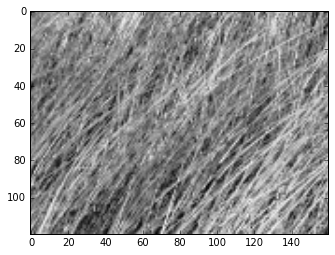

In [3]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [4]:
# Initialize the latent variable using PCA:
from sklearn.decomposition import PCA

N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)

sample = (sample - sample_mean)/sample_std # normalization
pca = PCA(n_components=Q) 
X = pca.fit_transform(sample) # performing PCA
print(X[0,:])

[ 23.73651164 -20.94734111  23.281226    22.6802055   -7.50919708
  34.30870091 -12.46201579   8.07417771 -12.95784813   9.80002935
  -6.88500422   0.63095893 -13.29798142  19.54781085  -4.42927045
   2.70507576  -5.53067023   4.97089492  -7.19820107  13.64289273]


## Kernels

<font color='red'>**Necessary kerns:**</font> 'lin','rbf','poly','ratquad','mlp','matern32'. Let's try to use GPy (Gaussian Process framework in python, from the Sheffield machine learning group). We'll get the following:

'lin' **class Linear**(input_dim, variances=None, ARD=False, active_dims=None, name='linear')

'rbf' **class RBF**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='rbf', useGPU=False, inv_l=False)

'poly' **class Poly**(input_dim, variance=1.0, scale=1.0, bias=1.0, order=3.0, active_dims=None, name='poly')

'ratquad' **class RatQuad**(input_dim, variance=1.0, lengthscale=None, power=2.0, ARD=False, active_dims=None, name='RatQuad')

'mlp' **class MLP**(input_dim, variance=1.0, weight_variance=1.0, bias_variance=1.0, ARD=False, active_dims=None, name='mlp')

'matern32' **class Matern32**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='Mat32')

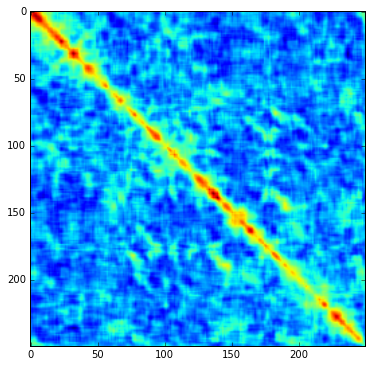

In [5]:
import GPy

fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Linear(Q).K(X,X))

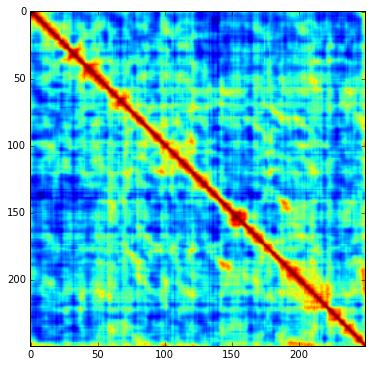

In [6]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RBF(Q,1,100).K(X,X))

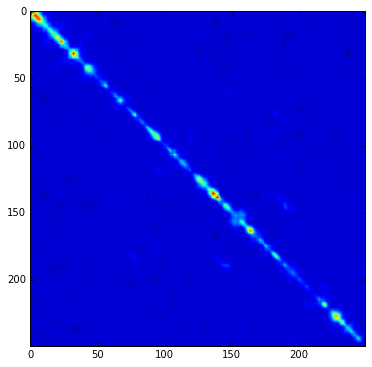

In [7]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Poly(Q,1,100).K(X,X))

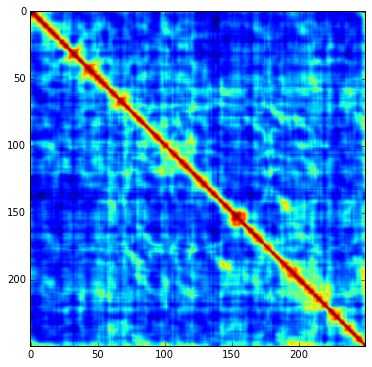

In [8]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RatQuad(Q,1,100).K(X,X))

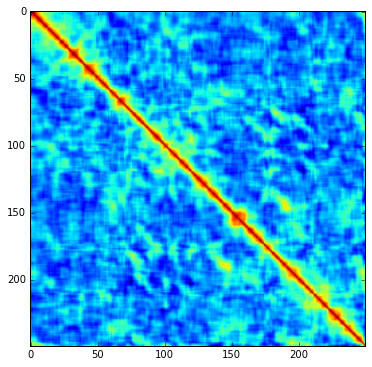

In [9]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.MLP(Q,1,100).K(X,X))

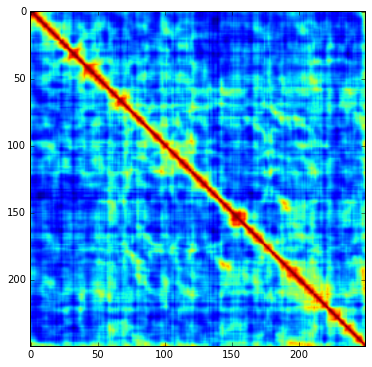

In [10]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Matern52(Q,1,100).K(X,X))

### Optimization

Kronecker Delta function:

In [50]:
def kd(x1,x2):
    
    if np.any(x1 == x2):
        return 1
    else:
        return 0

In [59]:
def kd2(N,x):
    
    result = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            result[i,j] = kd(x[i,:],x[j,:])
    
    return result

Kernel matrices:

In [170]:
def K_x(N,Q,w,x1,x2):
    
    k1 = GPy.kern.Linear(Q).K(x1[0:N-1,:],x2[0:N-1,:])
    k2 = GPy.kern.RBF(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    
    g = GPy.kern.RBF(Q,1,100)
    k = g.gradients_X
    
    k3 = GPy.kern.Poly(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k4 = GPy.kern.RatQuad(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k5 = GPy.kern.MLP(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k6 = GPy.kern.Matern52(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    
    #return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1[0:N-1,:],x2[0:N-1,:])
    return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd2(N-1,x1)

In [224]:
f = GPy.kern.RBF(Q,1,100).K(X)
g = GPy.kern.RBF(Q, 1,100).gradients_X(np.ones((1,1)), X)
print(f)
print(g)

[[ 1.          0.97398076  0.94107683 ...,  0.81815586  0.85101093  1.        ]
 [ 0.97398076  1.          0.98549815 ...,  0.76271269  0.79750592
   0.97398076]
 [ 0.94107683  0.98549815  1.         ...,  0.73676084  0.77379312
   0.94107683]
 ..., 
 [ 0.81815586  0.76271269  0.73676084 ...,  1.          0.94740378
   0.81815586]
 [ 0.85101093  0.79750592  0.77379312 ...,  0.94740378  1.          0.85101093]
 [ 1.          0.97398076  0.94107683 ...,  0.81815586  0.85101093  1.        ]]
[[-0.67994177  0.59832353 -0.67566439 ..., -0.14784931  0.21500271
  -0.40157602]
 [-0.71839623  0.6882898  -0.81635006 ..., -0.14521216  0.10656365
  -0.18436691]
 [-0.65724498  0.70700827 -0.76024724 ..., -0.18010383  0.08676469
  -0.06234769]
 ..., 
 [ 0.22536804  0.69643382 -0.51432735 ..., -0.39144151 -0.11633365
  -0.42034575]
 [-0.17184986  0.6451231  -0.43073901 ..., -0.14573711 -0.29908522
  -0.23999736]
 [-0.67994177  0.59832353 -0.67566439 ..., -0.14784931  0.21500271
  -0.40157602]]


In [180]:
b = GPy.kern.RBF(Q,1,100).dK2_drdr_via_X(X,X)
print(b)
print(np.size(b))

[[-1.         -0.92262522 -0.82677271 ..., -0.48974414 -0.57642322 -1.        ]
 [-0.92262522 -1.         -0.95670578 ..., -0.3495148  -0.43660894
  -0.92262522]
 [-0.82677271 -0.95670578 -1.         ..., -0.28661183 -0.37691349
  -0.82677271]
 ..., 
 [-0.48974414 -0.3495148  -0.28661183 ..., -1.         -0.84502752
  -0.48974414]
 [-0.57642322 -0.43660894 -0.37691349 ..., -0.84502752 -1.         -0.57642322]
 [-1.         -0.92262522 -0.82677271 ..., -0.48974414 -0.57642322 -1.        ]]
62500


In [222]:
help(GPy.kern.RBF)

Help on class RBF in module GPy.kern.src.rbf:

class RBF(GPy.kern.src.stationary.Stationary)
 |  Radial Basis Function kernel, aka squared-exponential, exponentiated quadratic or Gaussian kernel:
 |  
 |  .. math::
 |  
 |     k(r) = \sigma^2 \exp \bigg(- \frac{1}{2} r^2 \bigg)
 |  
 |  Method resolution order:
 |      RBF
 |      GPy.kern.src.stationary.Stationary
 |      GPy.kern.src.kern.Kern
 |      GPy.core.parameterization.parameterized.Parameterized
 |      paramz.parameterized.Parameterized
 |      GPy.core.parameterization.priorizable.Priorizable
 |      paramz.core.parameter_core.Parameterizable
 |      paramz.core.parameter_core.OptimizationHandlable
 |      paramz.core.constrainable.Constrainable
 |      paramz.core.indexable.Indexable
 |      paramz.core.nameable.Nameable
 |      paramz.core.gradcheckable.Gradcheckable
 |      paramz.core.pickleable.Pickleable
 |      paramz.core.parentable.Parentable
 |      paramz.core.updateable.Updateable
 |      paramz.core.observable

In [206]:
# Check which one is the gradient ?
GPy.models.GradientChecker(f,b,X.copy())

TypeError: 'numpy.ndarray' object is not callable

In [171]:
help(GPy.kern.RBF)

Help on class RBF in module GPy.kern.src.rbf:

class RBF(GPy.kern.src.stationary.Stationary)
 |  Radial Basis Function kernel, aka squared-exponential, exponentiated quadratic or Gaussian kernel:
 |  
 |  .. math::
 |  
 |     k(r) = \sigma^2 \exp \bigg(- \frac{1}{2} r^2 \bigg)
 |  
 |  Method resolution order:
 |      RBF
 |      GPy.kern.src.stationary.Stationary
 |      GPy.kern.src.kern.Kern
 |      GPy.core.parameterization.parameterized.Parameterized
 |      paramz.parameterized.Parameterized
 |      GPy.core.parameterization.priorizable.Priorizable
 |      paramz.core.parameter_core.Parameterizable
 |      paramz.core.parameter_core.OptimizationHandlable
 |      paramz.core.constrainable.Constrainable
 |      paramz.core.indexable.Indexable
 |      paramz.core.nameable.Nameable
 |      paramz.core.gradcheckable.Gradcheckable
 |      paramz.core.pickleable.Pickleable
 |      paramz.core.parentable.Parentable
 |      paramz.core.updateable.Updateable
 |      paramz.core.observable

In [199]:
help(GPy.models.GradientChecker)

Help on class GradientChecker in module GPy.models.gradient_checker:

class GradientChecker(GPy.core.model.Model)
 |  Say m is a handle to a parameterized class.
 |  
 |  Printing parameters::
 |  
 |      - print m:           prints a nice summary over all parameters
 |      - print m.name:      prints details for param with name 'name'
 |      - print m[regexp]: prints details for all the parameters
 |                           which match (!) regexp
 |      - print m['']:       prints details for all parameters
 |  
 |  Fields::
 |  
 |      Name:       The name of the param, can be renamed!
 |      Value:      Shape or value, if one-valued
 |      Constrain:  constraint of the param, curly "{c}" brackets indicate
 |                  some parameters are constrained by c. See detailed print
 |                  to get exact constraints.
 |      Tied_to:    which paramter it is tied to.
 |  
 |  Getting and setting parameters::
 |  
 |      - Set all values in param to one:      m.name

In [214]:
XX, ZZ = np.random.randn(10,3), np.random.randn(5,3)
kern = GPy.kern.Linear(3, ARD=True) + GPy.kern.RBF(3, ARD=True)
grad = GPy.models.GradientChecker(kern.K,lambda x: 2*kern.dK_dX(numpy.ones((1,1)), x),x0 = X.copy(),names='X')
grad.checkgrad(verbose=1)

              Name               |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
-----------------------------------------------------------------------------------------------------------------


AttributeError: 'Add' object has no attribute 'dK_dX'

In [88]:
def K_y(theta,x1,x2):
    
    return theta[0]*np.exp(-0.5*theta[1]*((x1 - x2)**2).sum(axis=-1))# + theta[2]*kd(x1,x2)

Functions to optimize:

In [164]:
def f1_likelihood(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    C = 0
    Kx_inv = np.linalg.inv(Kx)
    Ky_inv = np.linalg.inv(Ky)
    part1 = 0.5*D*np.log(np.linalg.det(Ky))
    part2 = 0.5*np.trace(np.matmul(Ky_inv,np.matmul(Y,np.linalg.pinv(Y))))
    part3 = 0.5*Q*np.log(np.linalg.det(Kx))
    part4 = 0.5*np.trace(np.matmul(Kx_inv,np.matmul(X[1:N],np.transpose(X[1:N]))))
    part5 = np.sum(theta)
    part6 = np.sum(lamb)
    
    return part1 + part2 + part3 + part4 + part5 + part6 + C

In [22]:
def f2_likelihood(N,Q,Kx,X,W):
    
    alpha = 1
    Kx_inv = np.linalg.inv(Kx)
    part1 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part2 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N])))
    part3 = alpha*np.linalg.norm(W,2)

    return part1 + part2 + part3

Kx kernel matrix test:

[[ 4707.46577625  5300.51240898  5432.67350878 ...,  1263.3018179
   1721.7195948   1707.08131007]
 [ 5300.51240898  6421.41032769  6751.19375397 ...,  1364.89793108
   1876.76047981  1914.4848525 ]
 [ 5432.67350878  6751.19375397  7373.51659116 ...,  1471.90906741
   2006.54533349  2088.61590912]
 ..., 
 [ 1263.3018179   1364.89793108  1471.90906741 ...,  4019.46086512
   2854.78261545  1325.66019282]
 [ 1721.7195948   1876.76047981  2006.54533349 ...,  2854.78261545
   2752.86384763  1803.35767487]
 [ 1707.08131007  1914.4848525   2088.61590912 ...,  1325.66019282
   1803.35767487  1935.77273337]]
1.51468158772e-12
-27.2158158722


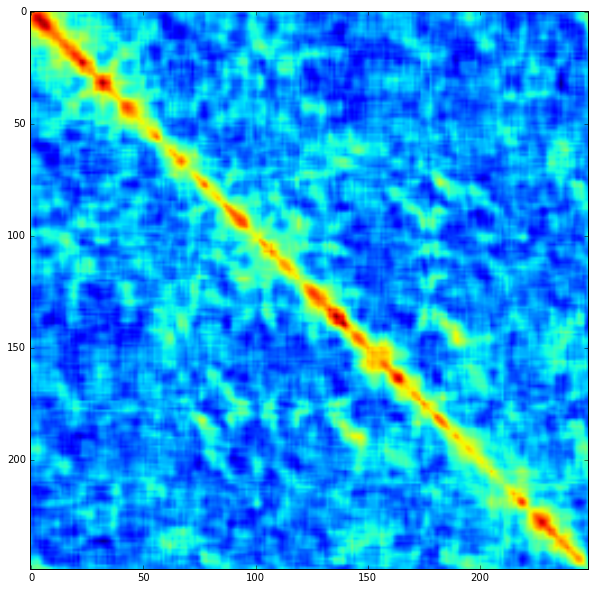

In [141]:
weights = [1, 1, 0, 1, 1, 1, 0]
Kx = K_x(N,Q,weights,X,X)

print(Kx)
print(np.linalg.det(Kx))
print(np.log(np.linalg.det(Kx)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Kx)

Ky kernel matrix test:

[[ 0.          0.97398076  0.94107683 ...,  0.81815586  0.85101093  0.        ]
 [ 0.97398076  0.          0.98549815 ...,  0.76271269  0.79750592
   0.97398076]
 [ 0.94107683  0.98549815  0.         ...,  0.73676084  0.77379312
   0.94107683]
 ..., 
 [ 0.81815586  0.76271269  0.73676084 ...,  0.          0.94740378
   0.81815586]
 [ 0.85101093  0.79750592  0.77379312 ...,  0.94740378  0.          0.85101093]
 [ 0.          0.97398076  0.94107683 ...,  0.81815586  0.85101093  0.        ]]
-59.9143511655


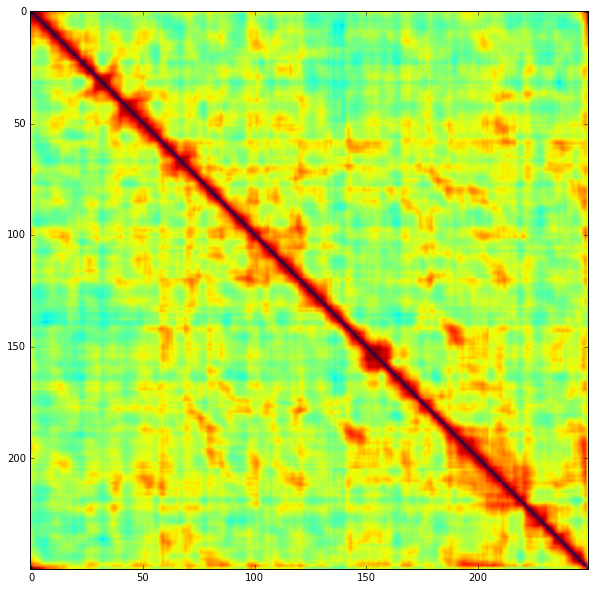

In [128]:
theta = [1, 0.0001, -1]
Ky = K_y(theta,X.reshape(1,-1,Q),X.reshape(-1,1,Q))
Ky = Ky + theta[2]*kd2(N,X)

print(Ky)
print(np.log(np.linalg.det(Ky)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Ky)

f1_likelihood test:

In [163]:
np.matmul(np.transpose(sample),np.matmul(np.linalg.inv(Ky),sample)).sum()

3.4442678842384811e+36

In [162]:
np.trace(np.matmul(np.linalg.inv(Ky),np.matmul(sample,np.linalg.pinv(sample))))

5.4909364046369292e+31

In [167]:
lamb = [1, 1, 1, 1, 1, 1]

print(f1_likelihood(N,D,Q,Kx,Ky,X,sample,theta,lamb))

2.74546820232e+31


f2_likelihood test:

In [168]:
#a = [[1,0,0],[0,1,0],[0,0,1]]
#x = [9,8,7,6]
#c = [1,2,3,4,5,6]
#print(f2_likelihood(20,4,a,x,c))

print(f2_likelihood(N,Q,Kx,X,weights))

2751387.38245


Gradients of functions f1 and f2:

In [19]:
def f1_gradient(Q,N,D,Kx,Ky,X,Y,theta,lamb):
    
    Kx_inv = np.linalg.inv(Kx)    
    Ky_inv = np.linalg.inv(Ky)
    
    dL_dX = dL_dKy * dKy_dX + dL_dKx * dKx_dX + dL_dx2 * dx2_dX
    
    dL_dKy = 0.5*D*np.transpose(Ky_inv)-0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))
    dL_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    dL_dx2 = 0.5*(np.matmul(Kx_inv,X[1:N])+np.matmul(np.transpose(Kx_inv),X[1:N]))
    
    #dKy_dX = ?
    #dKx_dX = ?
    #dx2_dX = ?
    
    dL_dTht1 = 0.5*D*np.trace(Ky_inv*dKy_dTht)
    dL_dTht2 = 0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))*dKy_dTht
    dL_dTht3 = 1/theta
    #dKy_dTht = ?
    
    dL_dLam1 = 0.5*Q*np.trace(Kx_inv*dKx_dLam)
    dL_dLam2 = 0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))*dKx_dTLam
    dL_dLam3 = 1/lamb
    #dKx_dLam = ?
    
    dL_dTht = dL_dTht1 - dL_dTht2 + dL_dTht3
    
    dL_dLam = dL_dLam1 - dL_dLam2 + dL_dLam3
    
    return [dL_dX, dL_dTheta, dL_dLam]

In [20]:
def f2_gradient(Q,N,Kx,X,W):
    
    #params = mk_weightsConstrain(params)
    
    #[Xin, Xout] = mk_priorIO(X, segments)
    
    Kx_inv = np.linalg.inv(Kx)
    #dL_dKx = -Q/2*invKx + 0.5*invKx*(Xout*Xout')*invKx
    
    #g = zeros(length(kern.comp),1)
    
    #for i = 1:length(kern.comp)
    #    g(i) = sum(sum(dL_dKx .* Kx{i}))
    
    norm2 = 1/np.linalg.norm(W,2)
    
    #for i = 1:length(kern.comp)
    #    g(i) = g(i) + norm2 * params(i)
    
    g = g/np.linalg.norm(g2)
    
    return -np.transpose(g)

In [21]:
# [params, options, flog] = scg('mk_likelihood', params, options, 'mk_gradient', Y, segments, kern)

# check weight_likelihood and mk_likelihood with Kx and Ky and rewrite if necessary

#write mk_weightsConstrain function
#write mk_priorIO function
#finish function weight_gradient

# search for kern gradients

# find scg function for Python